# Executive Summary (TLDR)

        The Home Mortgage Disclosure Act was enacted by Congress in 1975 out of concerns that financial institutions were perpetuating racial segregation. Large financial institutions have to keep a ledger with information on every home mortgage application they process which is published to the general public every year. The goal of this project was to analyze 2015 HMDA data about home mortgages in the state of MD and determine whether there is evidence of racial discrimination from the financial institutions and to build a model that can predict whether an individual will be approved for a loan.
        
        Visual inspection of the data revealed a sharp difference in loan approval rates between different racial groups. White people had the highest loan approval rate of 91.5% while black people had the lowest overall loan approval rate of 81.7%. However, this alone is not evidence that the distribution of loan acceptance between the two populations is even statistically significant. I used a Markov-chain Monte-carlo method to approximate the posterior distributions for white people as well as black people and was able to determine that there was in fact a significant difference between those two distributions.
        
        I then fit an xgboost model and a logistic regression model to the dataset. Both models performed very well with the xgboost model scoring .9573 Roc-AUC and the logit model scoring .960. In the xgboost model, race had a rather lower feature importance. Similarly in the logit model, race had a much smaller impact on loan approval rates than the strongest features. In this subset of the data at least, race of the loan applicant has very little impact on whether the loan gets approved or not.

# Intro

        The Home Mortgage Disclosure Act (HMDA) is a federal law that was passed by Congress in 1975 to address concerns that financial institutions were limiting home financing to qualified applicants in certain urban neighborhoods due to discriminatory practices. The HMDA requires that large financial institutions keep a record of relevant information for all home mortgage loan applicants including the race, sex, and ethnicity of the applicant, the amount of the loan requested, and the annual income of the applicant. The disclosed information also includes some general information about the Metropolitan Statistical Area/Metropolitan Division (MSA/MD) that the home is located in. The HMDA merely requires disclosure of this information. It does not require the financial institutions to meet any specific conditions as to their lending practices nor does the federal government provide any analysis of the data. Therefore, the HMDA relies on the general public to analyze and scrutinize the data made available.
        
        The goal of my project is to analyze the 2015 HMDA dataset for evidence of racial discrimination. I decided to focus my analysis exclusively on a subset of the HMDA data due to the sheer size of the dataset (it's a 4.9 gigabyte CSV file) and in order to increase the specificity of my results. I limited my analysis to mortgage requests in my home state of Maryland since that's the area of primary interest to me. I also decided to limit my analysis to loans for purchasing a single-family dwelling that are owner-occupied and secured by a first lien. My primary area of concern for this project is to detect whether financial institutions are perpetuating racial segregation, so I decided to excluded homes purchased for the purpose of renting and also loans for home improvement or refinancing. 

# EDA

In [1]:
import pandas as pd
hmda=pd.read_csv('hmda_lar.csv')
hmda.head()

/home/rb/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (23,24,25,28,29,30,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,state_name,...,applicant_sex_name,applicant_race_name_5,applicant_race_name_4,applicant_race_name_3,applicant_race_name_2,applicant_race_name_1,applicant_ethnicity_name,agency_name,agency_abbr,action_taken_name
0,78.989998,NaN,3773.0,79.510002,971.0,1428.0,152,89600.0,76.0,Maryland,...,"Information not provided by applicant in mail,...",NaN,NaN,NaN,NaN,"Information not provided by applicant in mail,...","Information not provided by applicant in mail,...",National Credit Union Administration,NCUA,Loan originated
1,91.209999,NaN,9732.0,16.920000,3206.0,3844.0,276,109400.0,109.0,Maryland,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Loan originated
2,114.089996,NaN,5721.0,88.779999,1604.0,1880.0,368,109400.0,95.0,Maryland,...,Female,NaN,NaN,NaN,NaN,Black or African American,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Loan originated
3,161.509995,NaN,5763.0,33.959999,1904.0,1789.0,284,89600.0,68.0,Maryland,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Loan originated
4,121.750000,NaN,6808.0,82.519997,2021.0,2149.0,406,109400.0,165.0,Maryland,...,Male,NaN,NaN,NaN,NaN,Black or African American,Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Loan originated


In [2]:
print hmda['action_taken_name'].value_counts()
print
print hmda['applicant_race_name_1'].value_counts()
print
print hmda['applicant_ethnicity_name'].value_counts()
print
print hmda['co_applicant_race_name_1'].value_counts()

Loan originated                                        61913
Application withdrawn by applicant                      9686
Application denied by financial institution             8095
Application approved but not accepted                   2528
File closed for incompleteness                          1876
Preapproval request denied by financial institution       17
Name: action_taken_name, dtype: int64

White                                                                                48177
Black or African American                                                            17780
Information not provided by applicant in mail, Internet, or telephone application    10853
Asian                                                                                 6707
American Indian or Alaska Native                                                       345
Native Hawaiian or Other Pacific Islander                                              238
Not applicable                                   

In [3]:
# Breakdown of most important features (determined later)
# purchaser_type_name, loan_type_name

print hmda['purchaser_type_name'].value_counts()
print
print hmda['loan_type_name'].value_counts()

Loan was not originated or was not sold in calendar year covered by register    33117
Life insurance company, credit union, mortgage bank, or finance company         11184
Commercial bank, savings bank or savings association                            10383
Ginnie Mae (GNMA)                                                                8920
Fannie Mae (FNMA)                                                                7972
Other type of purchaser                                                          6329
Freddie Mac (FHLMC)                                                              4894
Affiliate institution                                                             984
Private securitization                                                            320
Farmer Mac (FAMC)                                                                  12
Name: purchaser_type_name, dtype: int64

Conventional          43519
FHA-insured           27209
VA-guaranteed         10434
FSA/RHS-guarant

        Since the purpose of this analysis is to determine whether the financial institutions issuing the loans were engaging in discrimination, I dropped rows where the application was withdrawn by the applicant or closed for incompleteness. I also decided to drop observations where a preapproval was denied since this does not necessarily mean that the mortgage application would be denied overall and only 17/84115 observations in my dataset fell into this category.
        
        Where 'action_taken_name' was 'Application approved but not accepted', the financial institution initially approved the loan, but the loan applicant was unable to produce required documents to verify the information that the original approval was based on. I decided to consider these as applications that were closed due to incompleteness and remove these from my analysis as well.

In [4]:
#Let's encode action_taken_num as numbers
action_taken_num = hmda['action_taken_name'].factorize()
hmda['approved'] = action_taken_num[0]
print 'action_taken_num encoding'
for num, val in enumerate(action_taken_num[1]): 
    print str(num)+': '+val

#Keep only observations where action_taken_num is 0 or 2
filt_02 = [val in [0,2] for val in hmda['approved']]
hmda = hmda[filt_02]

#Let's encode applications that were approved as 1, denials as 0
approved = [ 1 if val==0 else 0 for val in hmda['approved']]
hmda['approved'] = approved
accepted = hmda['approved'].sum()
denied = len(hmda) - hmda['approved'].sum()
print
print 'Accepted: ' + str(accepted)
print 'Denied: ' + str(denied)
print
print '% Approved: ' + str( float(accepted) / (accepted + denied))

action_taken_num encoding
0: Loan originated
1: Application approved but not accepted
2: Application denied by financial institution
3: Application withdrawn by applicant
4: File closed for incompleteness
5: Preapproval request denied by financial institution

Accepted: 61913
Denied: 8095

% Approved: 0.884370357673


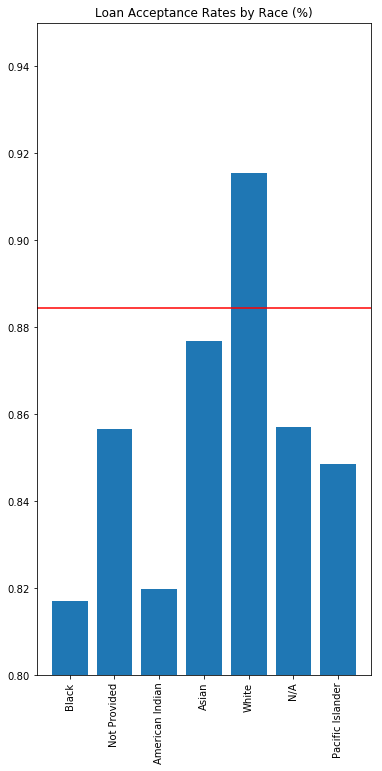

In [5]:
#Are there differences between races in the percentage of applicants that had their mortgage approved?
import matplotlib.pyplot as plt

#Put the approval rates in a dictionary
approval_rate_by_race = {}
for race in hmda['applicant_race_name_1'].value_counts().index:
    by_race = hmda[ hmda['applicant_race_name_1'] == race]['approved']
    approval_rate_by_race[race] = float( by_race.sum()) / len(by_race)
    
#Bar chart of acceptance rates by race
plt.clf()
fig, ax = plt.subplots( figsize=(6,12))
ax.bar( range(7), approval_rate_by_race.values())

#White:4, Asian:3, N/A:5, Not Provided:1, Pacific Islander:6, American Indian:2, Black:0
labels = ['', 'Black', 'Not Provided', 'American Indian', 'Asian', 'White', 'N/A', 'Pacific Islander']
ax.set_xticklabels(labels, rotation='vertical')

plt.ylim((.80,.95))
plt.title('Loan Acceptance Rates by Race (%)')
plt.axhline(float(accepted) / (accepted + denied), color='red')

#ax.set_xticklabels(approval_rate_by_race.keys(), rotation=90)
plt.show()

In [6]:
sorted(approval_rate_by_race.items(), key=lambda x: x[1])

[('Black or African American', 0.8169661512745507),
 ('American Indian or Alaska Native', 0.8198529411764706),
 ('Native Hawaiian or Other Pacific Islander', 0.8484848484848485),
 ('Information not provided by applicant in mail, Internet, or telephone application',
  0.8565116279069768),
 ('Not applicable', 0.8571428571428571),
 ('Asian', 0.8768703803857941),
 ('White', 0.9154294351398132)]

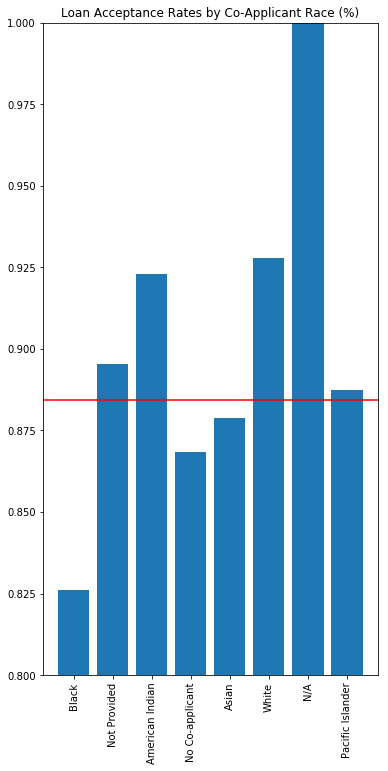

In [7]:
#What about race of the co-applicant?

#Put the approval rates in a dictionary
approval_rate_by_race_co = {}
for race in hmda['co_applicant_race_name_1'].value_counts().index:
    by_race = hmda[ hmda['co_applicant_race_name_1'] == race]['approved']
    approval_rate_by_race_co[race] = float( by_race.sum()) / len(by_race)
    
#Bar chart of acceptance rates by race
plt.clf()
fig, ax = plt.subplots( figsize=(6,12))
ax.bar( range(8), approval_rate_by_race_co.values())

labels = ['', 'Black', 'Not Provided', 'American Indian', 'No Co-applicant', 'Asian', 'White', 'N/A', 'Pacific Islander']
ax.set_xticklabels(labels, rotation='vertical')

plt.ylim((.80,1))
plt.title('Loan Acceptance Rates by Co-Applicant Race (%)')
plt.axhline(float(accepted) / (accepted + denied), color='red')

#ax.set_xticklabels(approval_rate_by_race.keys(), rotation=90)
plt.show()

In [8]:
sorted(approval_rate_by_race_co.items(), key=lambda x: x[1])

[('Black or African American', 0.8261612995155315),
 ('No co-applicant', 0.8682621502209131),
 ('Asian', 0.8786936236391913),
 ('Native Hawaiian or Other Pacific Islander', 0.8875),
 ('Information not provided by applicant in mail, Internet, or telephone application',
  0.8953985416142821),
 ('American Indian or Alaska Native', 0.9230769230769231),
 ('White', 0.9278020072513268),
 ('Not applicable', 1.0)]

        While there seems to be a pretty notable difference between the approval rates by race, this does not necessarily mean that there is active racial discrimination happening, nor does it necessarily mean that the differences in approval rates between different races was statistically significant. I will use a Bayesian analysis to determine whether the difference in approval rates between the white and black populations is statistically significant. Furthermore, I will build the best tree-based predictive model I can and identify how important race was as a feature for that model. Lastly, I will build a logistic regression model so I can identify how big of a difference race made as a predictor for my variable.

# Bayesian Inference

        The largest difference in loan approval rates between racial categories was between whites and blacks with 91.54% and 81.70% home loan acceptance rates respectively. 

In [9]:
#Isolate 2 populations

whites = list( hmda[ hmda['applicant_race_name_1']=='White']['approved'])
blacks = list( hmda[ hmda['applicant_race_name_1']=='Black or African American']['approved'])

In [10]:
import pymc3 as pm
import numpy as np

#Normal prior? what std to use?

all_p_mean = np.mean( whites + blacks)
all_p_std = np.std( whites + blacks) / np.sqrt( len( whites + blacks))

#Set up prior

with pm.Model() as model:
    
    whites_p = pm.Normal('Whites_p', all_p_mean, sd=all_p_std)
    blacks_p = pm.Normal('Blacks_p', all_p_mean, sd=all_p_std)

In [11]:
all_p_std
all_p_mean

0.88990013904689669

In [12]:
#Set up Bernoulli dists for 2 populations

with model:
    
    whites_dist = pm.Bernoulli('Whites', p=whites_p , observed=whites)
    blacks_dist = pm.Bernoulli('Blacks', p=blacks_p , observed=blacks)

In [13]:
%time
with model:
    trace = pm.sample(25000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


Average Loss = inf:   5%|▍         | 9933/200000 [00:04<01:35, 1994.18it/s]
Convergence archived at 10000
Interrupted at 10,000 [5%]: Average Loss = 64,013
100%|██████████| 25500/25500 [01:03<00:00, 403.70it/s]


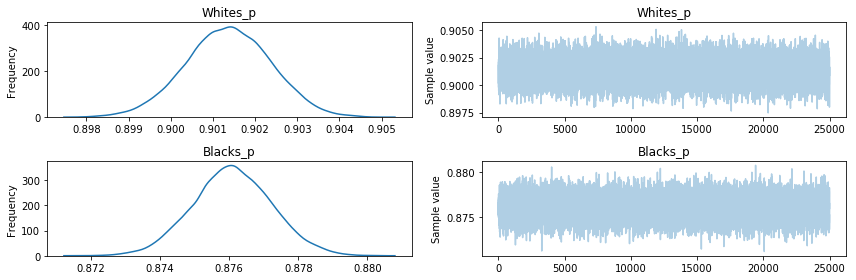

In [14]:
pm.traceplot(trace)
plt.show()

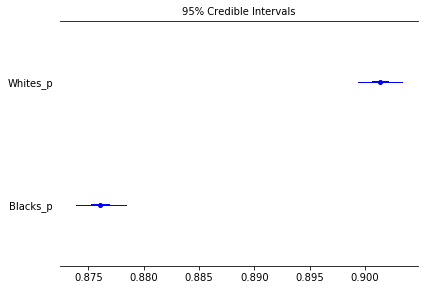

In [15]:
pm.forestplot(trace[3000:], varnames=[v.name for v in model.vars])
plt.show()

# Data Munging

        Since I limited my analysis to home mortgage applications in Maryland that were secured by a first lien, I was able to remove several features from my model that were consistent across all observations in my data subset. I also decided to remove the census tract number since it subdivides the data into too many inconsistently sized samples to form an accurate model. I did however keep all other information about the geographical area that each home was in.
        
        The agency referred to in the agency name and agency abbreviation columns is the federal agency that each entry in our database was reported to. Because the federal agency was only a recipient of the information and had no active role in deciding whether to approve or deny each loan, it makes little sense to use this as a predictor in my model. 
        
        Sequence number is merely a unique ID that was assigned to each case. Therefore, it will have no predictive power and should be dropped from the predictive features for my model. 
        
        Since I encoded action_taken_name as 1s and 0s (for approved and denied respectively) in the 'approved' column, I will remove that as well from my dataset.
        
        The HMDA data has 5 columns to indicate race in case anybody identifies with multiple races. However, this information was very sparse for the applicant_race_2 - applicant_race_5 columns as well as the co_applicant_race_name_1 - co_applicant_race_name_2, so I decided to drop those columns from my model. Given more time, I would like to find a way to account for subcategories of race in my model.
        
        I also decided to remove the reason for denial from my predictive model since it would make no sense to use that to predict whether a loan was approved or not.
        
        There were also only 15 observations where race was listed as 'Not Applicable', 54 observations where ethnicity was listed as 'Not Applicable' and 14 observations where sex was listed as 'Not Applicable'. Since the goal of my project is to determine if there is discrimination happening on the basis of these factors, I needed to find some way to handle these observations. Due to the extremely small sample size of these classes, I decided it would be much easier to just drop them from my dataset.
        
        Finally, since only 2 out of the remaining 69969 observations were HOEPA loans, I decided to filter out those observations and drop the relevant column. Therefore, it should be noted that my analysis will focus only on non-HOEPA loans. 

In [16]:
#Drop features that I chose not to use a predictors
hmda.drop(['application_date_indicator', 'as_of_year', 'state_name', 
          'state_abbr', 'census_tract_number', 'lien_status_name',
          'sequence_number', 'action_taken_name', 'agency_name', 'agency_abbr',
          'loan_purpose_name', 'rate_spread', 'preapproval_name', 
          'owner_occupancy_name', 'property_type_name', 'edit_status_name', 'respondent_id'], 
          axis=1, inplace=True)

#Drop sparse subdivisions of race and denial reason
for i in range(2,6):
    hmda.drop('applicant_race_name_'+str(i), axis=1, inplace=True)
    hmda.drop('co_applicant_race_name_'+str(i), axis=1, inplace=True)
    
for i in range(1,4):
    hmda.drop('denial_reason_name_'+str(i), axis=1, inplace=True)
    
#Filter out 'Not applicable's for the main applicant
filt_NA = [val!='Not applicable' for val in hmda['applicant_race_name_1']]
hmda = hmda[filt_NA]

filt_NA = [val!='Not applicable' for val in hmda['applicant_ethnicity_name']]
hmda = hmda[filt_NA]

filt_NA = [val!='Not applicable' for val in hmda['applicant_sex_name']]
hmda = hmda[filt_NA]

#Do the same for co_applicant data
filt_NA = [val!='Not applicable' for val in hmda['co_applicant_race_name_1']]
hmda = hmda[filt_NA]

filt_NA = [val!='Not applicable' for val in hmda['co_applicant_ethnicity_name']]
hmda = hmda[filt_NA]

filt_NA = [val!='Not applicable' for val in hmda['co_applicant_sex_name']]
hmda = hmda[filt_NA]

#Filter out HOEPA loans
filt_hoepa = [val!='HOEPA loan' for val in hmda['hoepa_status_name']]
hmda = hmda[filt_hoepa]
hmda.drop('hoepa_status_name', axis=1, inplace=True)

In [17]:
# These are the features that I will be using for my predictive model split into categorical and numerical data.

num_cols = list( hmda.describe().columns.values)
cat_cols = list( hmda.columns.values)
for col in num_cols:
    cat_cols.remove(col)
print 'Categorical Features:'
print cat_cols
print
print 'Numerical Features:'
print num_cols

Categorical Features:
['purchaser_type_name', 'msamd_name', 'loan_type_name', 'county_name', 'co_applicant_sex_name', 'co_applicant_race_name_1', 'co_applicant_ethnicity_name', 'applicant_sex_name', 'applicant_race_name_1', 'applicant_ethnicity_name']

Numerical Features:
['tract_to_msamd_income', 'population', 'minority_population', 'number_of_owner_occupied_units', 'number_of_1_to_4_family_units', 'loan_amount_000s', 'hud_median_family_income', 'applicant_income_000s', 'approved']


In [18]:
hmda[num_cols].describe()

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,approved
count,69927.000000,69928.000000,69928.000000,69799.000000,69928.000000,69967.000000,69928.000000,69547.000000,69967.000000
mean,109.602302,4959.785966,40.261576,1368.827877,1612.455812,308.095859,97618.450406,108.765497,0.884374
std,35.519222,1756.833173,28.717755,551.076239,633.139986,180.151775,14406.629127,101.603088,0.319778
min,8.880000,773.000000,1.560000,8.000000,17.000000,3.000000,51600.000000,1.000000,0.000000
25%,86.150002,3661.000000,15.700000,974.000000,1173.000000,195.000000,89600.000000,59.000000,1.000000
50%,106.449997,4798.000000,31.809999,1318.000000,1555.000000,273.000000,89600.000000,87.000000,1.000000
75%,127.349998,6122.000000,63.040001,1754.000000,1993.000000,381.000000,109400.000000,130.000000,1.000000
max,243.479996,15934.000000,99.610001,3206.000000,5315.000000,4000.000000,115000.000000,6785.000000,1.000000


        Thankfully, this dataset was very clean. I went through the categorical columns one-by-one and was unable to find any misspellings or other obvious clerical errors. I'm satisfied that all of the remaining categorical columns can be factorized or dummified and used for building a predictive model. Similarly, when it comes to the numerical data, visual inspection of the summary statistics revealed no obvious clerical errors. Other than that, it would be very difficult to verify the integrity of these numbers. However, judging by the extreme cleanliness of the categorical data, I believe that it will be safe to build my model using these numerican features.

# Choosing a Model

        I then tried several tree-based models. In my experience, these are usually the best-performing models for classification problems. Another big advantage is that I can simply factorize my categorical columns, and the tree-based models will deal with them appropriately. Also, there is no need to scale my numerical data. The code for this is simple. 
        Because of the highly imbalanced classes in my original data, I chose to evaluate my different classification models on their roc_auc scores.

In [19]:
#Create new dataframe, df, with data ready to be fed into a model 
#This way I can avoid tampering with the original

df = pd.DataFrame()

for col in cat_cols:
    df[col] = hmda[col].factorize()[0]

for col in num_cols:
    df[col] = hmda[col]
    
#Let's create a new column with the ratio of the loan amount to applicant income
df['loan_to_income'] = df['loan_amount_000s']/df['applicant_income_000s']

#Drop observations with missing values
df.dropna(inplace=True)

#Our y variable is the approval status, our X variables are every other column
X = df.drop('approved', axis=1).copy(deep=True)
y = df['approved'].copy(deep=True)

In [20]:
#Random forest model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rforest_model = RandomForestClassifier()
scores = cross_val_score( rforest_model, X, y, cv=10, scoring='roc_auc')
print 'Avg Score: ' + str(scores.mean())
print 'Std. Dev.: ' + str(scores.std())

Avg Score: 0.922791266083
Std. Dev.: 0.0145221186152


In [21]:
#Extra-random trees model
from sklearn.ensemble import ExtraTreesClassifier

xtrees_model = ExtraTreesClassifier()
scores = cross_val_score( xtrees_model, X, y, cv=10, scoring='roc_auc')
print 'Avg Score: ' + str(scores.mean())
print 'Std. Dev.: ' + str(scores.std())

Avg Score: 0.906214535369
Std. Dev.: 0.0142859519299


In [22]:
#Xgboost Classifier model
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
scores = cross_val_score( xgb_model, X, y, cv=10, scoring='roc_auc')
print 'Avg Score: ' + str(scores.mean())
print 'Std. Dev.: ' + str(scores.std())

/home/rb/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Avg Score: 0.956841609663
Std. Dev.: 0.0160484389915


# Final Predictive Model

        Xgboost was the clear winner out of the different model types. First I performed a gridsearch to find the best parameters possible for this model. I then performed a simple train_test split on my dataframe so I could evaluate the effectiveness of my final model. The feature importance for each feature will in essence tell us how much of the discriminatory power of the model can be attributed to each feature. I measured the feature importances three different ways.

In [23]:
#Gridsearch for the best tuning parameters 
from sklearn.model_selection import GridSearchCV

xgb_params = {'max_depth': [1, 3, 6, 10, 15],
             'learning_rate': [.01, .1, 1, 10]}

xgb_grid = GridSearchCV( XGBClassifier(), param_grid=xgb_params, n_jobs=-1, verbose=1)

xgb_grid.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1, 1, 10], 'max_depth': [1, 3, 6, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

print 'Best Tuning Parameters:' + str( xgb_grid.best_params_)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=.1)

#Fit model
xgb_model = xgb_grid.best_estimator_
xgb_model.fit( X_train, y_train)

#Predict probas and find roc_auc score
y_pred = [pair[1] for pair in xgb_model.predict_proba( X_test)]
print 'Roc-AUC score: ' + str( roc_auc_score( y_test, y_pred))

Best Tuning Parameters:{'learning_rate': 0.1, 'max_depth': 3}
Roc-AUC score: 0.959369837396


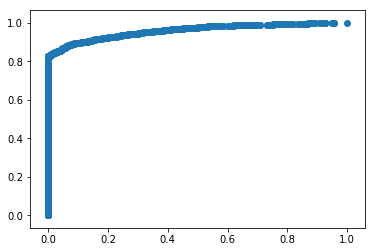

In [25]:
# Display the roc curve
from sklearn.metrics import roc_curve

plt.clf()
fpr, tpr, threshold = roc_curve( y_test, y_pred)
plt.scatter( fpr, tpr)
plt.show()

# How Important is Race to The Final Predictive Model?

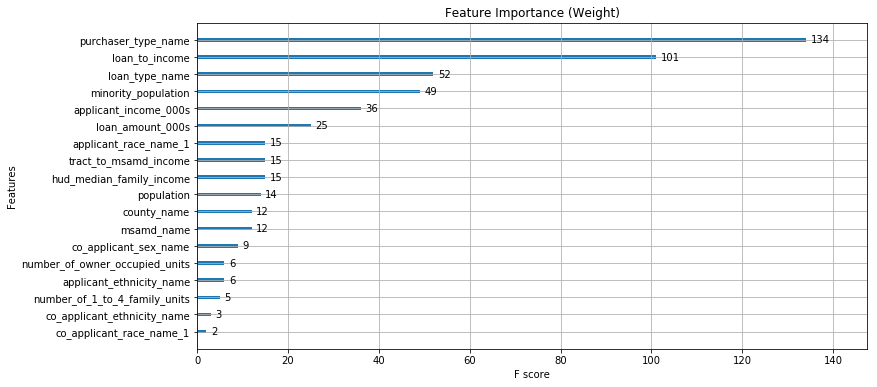

In [26]:
from xgboost import plot_importance

plt.clf()
fig, ax = plt.subplots( figsize=(12,6))

plot_importance( xgb_model, ax=ax)
plt.title('Feature Importance (Weight)')
plt.show()

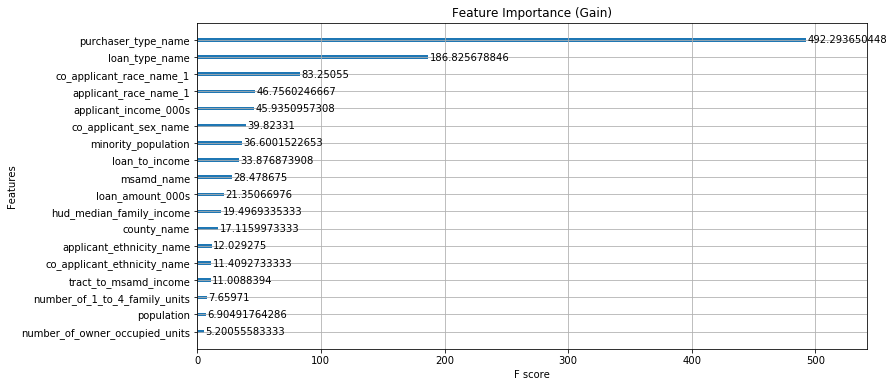

In [27]:
plt.clf()
fig, ax = plt.subplots( figsize=(12,6))

plot_importance( xgb_model, ax=ax, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()

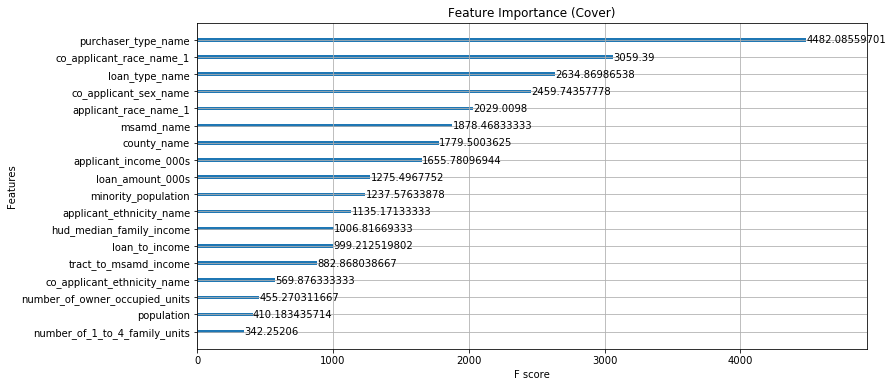

In [28]:
plt.clf()
fig, ax = plt.subplots( figsize=(12,6))

plot_importance( xgb_model, ax=ax, importance_type='cover')
plt.title('Feature Importance (Cover)')
plt.show()

In [29]:
#How well does the same model perform when the applicant_race_name_1 and 
# co_applicant_race_name_1 columns are removed?

X_train_r = X_train.drop(['applicant_race_name_1', 'co_applicant_race_name_1'], axis=1).copy(deep=True)
X_test_r = X_test.drop(['applicant_race_name_1', 'co_applicant_race_name_1'], axis=1).copy(deep=True)

xgb_model.fit(X_train_r, y_train)

#Scoring
y_pred = [pair[1] for pair in xgb_model.predict_proba( X_test_r)]
print 'Roc-AUC score: ' + str( roc_auc_score( y_test, y_pred))

Roc-AUC score: 0.95842014226


# An Inferential Model (Logistic Regression)

In [30]:
#Create a new df to store data suitable for logistic regression
#For this model, I will need to scale all of the numerical data
#Instead of factorizing categorical columns as before, I will have to split them into dummy columns
#From each categorical feature I will choose one category to be the baseline and drop the corresponding column
from sklearn.preprocessing import StandardScaler

#Reset num_cols and cat_cols, remove 'approved' from num_cols
num_cols = list( hmda.describe().columns.values)
cat_cols = list( hmda.columns.values)
for col in num_cols:
    cat_cols.remove(col)
num_cols.remove('approved')

# Generate dummy columns
df_cat = pd.get_dummies( hmda[cat_cols])

#Choose most populous dummy columns to be the baseline
baseline={}
for col in cat_cols:
    baseline[col] = hmda[col].value_counts().index[0]

#Remove those from the model
for key,value in baseline.iteritems():
    drop_col = key + '_' + value
    df_cat.drop(drop_col, axis=1, inplace=True)

In [31]:
#Combine with numerical columns and drop observations with missing values
df_num = hmda[ num_cols].copy( deep=True)
df_num['approved'] = hmda['approved'].copy( deep=True)
df_i = pd.concat( [df_cat, df_num], axis=1).dropna()

#Separate numerical columns and scale them, remove approved from num_cols to preserve 0/1 values
df_num = pd.DataFrame( StandardScaler().fit_transform( df_i[ num_cols]), 
                     columns = num_cols)
df_i.drop( num_cols, axis=1, inplace=True)

In [32]:
#Reset index
df_i.reset_index(inplace=True)
df_num.reset_index(inplace=True)
df_i = pd.concat([df_i, df_num], axis=1)
df_i.drop('index', axis=1, inplace=True)

In [33]:
#Separate X and y
X = df_i.drop('approved', axis=1)
y = df_i['approved']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=.1)

In [34]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression().fit( X_train, y_train)
y_pred = [_[1] for _ in log_model.predict_proba( X_test)]

print 'Roc-AUC score: ' + str( roc_auc_score( y_test, y_pred))

Roc-AUC score: 0.958985079891


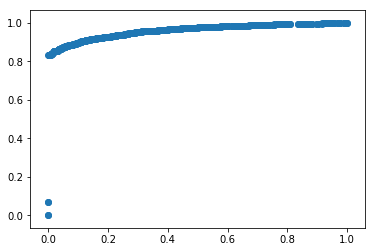

In [35]:
#Plot Roc curve

plt.clf()
fpr, tpr, threshold = roc_curve( y_test, y_pred)
plt.scatter( fpr, tpr)
plt.show()

In [36]:
feat_coefs = []

#Zip feature names and coefficients into list of tuples
for var, val in zip( X_train.columns.values, log_model.coef_[0]):
    feat_coefs.append( (var, val))

#Sort it
feat_coefs.sort(key=lambda tup: tup[1], reverse=True)

print 'Race and Odds of Getting a Loan (Relative to White)'
print
for _ in feat_coefs: 
    if ('applicant_race_name' in _[0]) and ('_app' not in _[0]):
        print _[0][22:] + ': ' + str( np.exp(_[1]))

Race and Odds of Getting a Loan (Relative to White)

Information not provided by applicant in mail, Internet, or telephone application: 0.998799909066
Black or African American: 0.726503222947
Asian: 0.646744460905
American Indian or Alaska Native: 0.549431158253
Native Hawaiian or Other Pacific Islander: 0.473843776948


In [37]:
for _ in feat_coefs:
    print _

('purchaser_type_name_Life insurance company, credit union, mortgage bank, or finance company', 7.7832152202428997)
('purchaser_type_name_Ginnie Mae (GNMA)', 7.7397663379795665)
('purchaser_type_name_Commercial bank, savings bank or savings association', 7.4654684455983142)
('purchaser_type_name_Other type of purchaser', 7.2728309147270522)
('purchaser_type_name_Fannie Mae (FNMA)', 6.220931372602208)
('purchaser_type_name_Freddie Mac (FHLMC)', 5.8654999741500387)
('purchaser_type_name_Affiliate institution', 4.4317705234482174)
('purchaser_type_name_Private securitization', 3.6407175106108522)
('purchaser_type_name_Farmer Mac (FAMC)', 2.5881731797782042)
('msamd_name_California, Lexington Park - MD', 0.35819742939534766)
("county_name_St. Mary's County", 0.35819742939534766)
('county_name_Kent County', 0.35043839107979408)
('msamd_name_Silver Spring, Frederick, Rockville - MD', 0.31969955023387736)
('applicant_income_000s', 0.31424549264565688)
('co_applicant_race_name_1_Information no

# Is There Evidence of Racial Discrimination?

        In my final tuned Xgboost Classifier model, for all 3 measures of feature importances, race of the applicant had a relatively small impact on the model as compared to my other features. Co-applicant race had a much larger impact on my model than applicant race. However, this does not mean much since the most common value for co-applicant race was 'No coapplicant', and whether or not there was a co-applicant should logically have a very high impact on whether a loan was approved or not. Similarly, in the logistic regression, race did have an impact on the model, but the size of that impact was dwarfed by the impact the best predictors had. This does seem to indicate that race was not an important factor in determining whether a loan got approved.

# Stakeholder Recommendations and Next Steps

        Given more time, I would like to expand my analysis to cover the entire HMDA database from 2015 rather than just a limited subset. Most importantly, I would like to expand my analysis to cover the entirety of the US. In addition to expanding my analysis within the 2015 data, I would like to use the HMDA data from all previous years (1976-2015) and look for evidence of racial discrimination. It would be particularly interesting to see if and how racial discrimination from the financial industry has evolved over the past 40 years.
        
        While doing research on home mortgage loan availability data, I also stumbled across another dataset published by Freddie Mac, the Single-Family Loan-Level Dataset. This dataset includes the credit score of loan applicants, which I would think is one of the single greatest predictive factors for whether a loan gets approved or not. Race had a small but non-negligible impact on the performance of my model. However, race is correlated with credit scores, and without information on the credit scores, race will naturally account for some of that predictive power.